<a href="https://colab.research.google.com/github/jaswanth9949/ML/blob/main/brain_mri_segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from PIL import Image
from glob import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [ ]:

images = []
mask = glob('/content/drive/MyDrive/archive.zip (Unzipped Files)/kaggle_3m/*/*_mask*')

for i in mask:
    images.append(i.replace('_mask',''))

print(images[:5])
print('-------------------')
print(mask[:5])

['/content/drive/MyDrive/archive.zip (Unzipped Files)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_10.tif', '/content/drive/MyDrive/archive.zip (Unzipped Files)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_11.tif', '/content/drive/MyDrive/archive.zip (Unzipped Files)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_12.tif', '/content/drive/MyDrive/archive.zip (Unzipped Files)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_13.tif', '/content/drive/MyDrive/archive.zip (Unzipped Files)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_14.tif']
-------------------
['/content/drive/MyDrive/archive.zip (Unzipped Files)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_10_mask.tif', '/content/drive/MyDrive/archive.zip (Unzipped Files)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_11_mask.tif', '/content/drive/MyDrive/archive.zip (Unzipped Files)/kaggle_3m/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_12_mask.tif', '/content/drive/MyDrive/archive.zip

# Create a dataframe

In [ ]:
data = pd.DataFrame({'images':images,'masks':mask})
data.head(9)

,images,masks
0,/content/drive/MyDrive/archive.zip (Unzipped F...,/content/drive/MyDrive/archive.zip (Unzipped F...
1,/content/drive/MyDrive/archive.zip (Unzipped F...,/content/drive/MyDrive/archive.zip (Unzipped F...
2,/content/drive/MyDrive/archive.zip (Unzipped F...,/content/drive/MyDrive/archive.zip (Unzipped F...
3,/content/drive/MyDrive/archive.zip (Unzipped F...,/content/drive/MyDrive/archive.zip (Unzipped F...
4,/content/drive/MyDrive/archive.zip (Unzipped F...,/content/drive/MyDrive/archive.zip (Unzipped F...
5,/content/drive/MyDrive/archive.zip (Unzipped F...,/content/drive/MyDrive/archive.zip (Unzipped F...
6,/content/drive/MyDrive/archive.zip (Unzipped F...,/content/drive/MyDrive/archive.zip (Unzipped F...
7,/content/drive/MyDrive/archive.zip (Unzipped F...,/content/drive/MyDrive/archive.zip (Unzipped F...
8,/content/drive/MyDrive/archive.zip (Unzipped F...,/content/drive/MyDrive/archive.zip (Unzipped F...


In [ ]:
data.shape

(3929, 2)

In [ ]:
data=pd.DataFrame(data.iloc[0:500,:],columns=data.columns)

In [ ]:
data.shape

(500, 2)

# Viz data

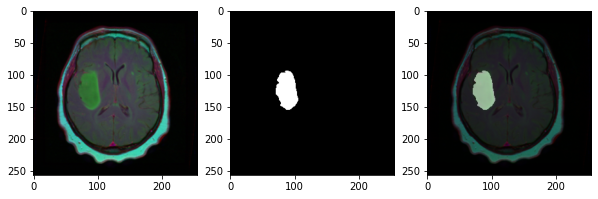

In [ ]:
import cv2 
N=1
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
img=cv2.imread(data.images.iloc[N])
plt.imshow(img)
plt.subplot(1,3,2)
msk=cv2.imread(data.masks.iloc[N])
plt.imshow(msk)
plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(msk,alpha=0.5)

# Split data

In [ ]:
data_train,data_test=train_test_split(data,test_size=0.1)

data_train,data_val=train_test_split(data_train,test_size=0.2)


In [ ]:
datagen = ImageDataGenerator(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest',
                            rescale=1./255)


In [ ]:
image_train=datagen.flow_from_dataframe(data_train,  
                                    target_size=(256,256), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=42,
                                    x_col ="images", 
                                    batch_size=10,
                                    class_mode=None
                                    
)
mask_train=datagen.flow_from_dataframe(data_train, 
                                    target_size=(256,256), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=42,
                                    x_col ="masks", 
                                    batch_size=10,
                                    class_mode=None
)

Found 360 validated image filenames.
Found 360 validated image filenames.


In [ ]:
image_validation=datagen.flow_from_dataframe(data_val,  
                                    target_size=(256,256), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=42,
                                    x_col ="images", 
                                    batch_size=10,
                                    class_mode=None
)

mask_validation=datagen.flow_from_dataframe(data_val, 
                                    target_size=(256,256), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=42,
                                    x_col ="masks", 
                                    batch_size=10,
                                    class_mode=None
)

Found 90 validated image filenames.
Found 90 validated image filenames.


In [ ]:
train_gen=zip(image_train,mask_train)
valid_gen=zip(image_validation,mask_validation)

# Create Model

In [ ]:
def unet(input_size=(256,256,3)):
    inputs = layers.Input(input_size)
    
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = layers.BatchNormalization(axis=3)(conv1)
    bn1 = layers.Activation('relu')(bn1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = layers.Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = layers.BatchNormalization(axis=3)(conv2)
    bn2 = layers.Activation('relu')(bn2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = layers.Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = layers.BatchNormalization(axis=3)(conv3)
    bn3 = layers.Activation('relu')(bn3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = layers.Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = layers.BatchNormalization(axis=3)(conv4)
    bn4 = layers.Activation('relu')(bn4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = layers.BatchNormalization(axis=3)(conv5)
    bn5 = layers.Activation('relu')(bn5)

    up6 = layers.concatenate([layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = layers.BatchNormalization(axis=3)(conv6)
    bn6 = layers.Activation('relu')(bn6)

    up7 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = layers.BatchNormalization(axis=3)(conv7)
    bn7 = layers.Activation('relu')(bn7)

    up8 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = layers.Activation('relu')(conv8)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = layers.BatchNormalization(axis=3)(conv8)
    bn8 = layers.Activation('relu')(bn8)

    up9 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = layers.Activation('relu')(conv9)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = layers.BatchNormalization(axis=3)(conv9)
    bn9 = layers.Activation('relu')(bn9)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return models.Model(inputs=[inputs], outputs=[conv10])

# Dice coeff (loss and metrics)

In [ ]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

In [ ]:
model = unet(input_size=(256, 256, 3))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[dice_coef,'accuracy'])


# Train the model

In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=15,
    validation_steps=len(data_val) //10,
    steps_per_epoch=len(data_train) //10
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


36/36 [==============================] - 235s 6s/step - loss: 1.2442 - dice_coef: 0.0285 - accuracy: 0.9273 - val_loss: 1.4124 - val_dice_coef: 0.0154 - val_accuracy: 0.8701
Epoch 2/15
36/36 [==============================] - 43s 1s/step - loss: 1.0018 - dice_coef: 0.1021 - accuracy: 0.9857 - val_loss: 1.1454 - val_dice_coef: 0.0293 - val_accuracy: 0.9907
Epoch 3/15
36/36 [==============================] - 43s 1s/step - loss: 0.8881 - dice_coef: 0.1785 - accuracy: 0.9862 - val_loss: 1.0884 - val_dice_coef: 0.0180 - val_accuracy: 0.9910
Epoch 4/15
36/36 [==============================] - 43s 1s/step - loss: 0.7573 - dice_coef: 0.2876 - accuracy: 0.9887 - val_loss: 1.0329 - val_dice_coef: 0.0145 - val_accuracy: 0.9944
Epoch 5/15
36/36 [==============================] - 43s 1s/step - loss: 0.6999 - dice_coef: 0.3410 - accuracy: 0.9896 - val_loss: 0.9752 - val_dice_coef: 0.0685 - val_accuracy: 0.9897
Epoch 6/15
36/36 [==============================] - 43s 1s/step - loss: 0.7278 - dice_coef

# Evaluate the model 

In [ ]:
eval_results = model.evaluate(valid_gen, steps=len(data_val) /10, verbose=1)

9/9 [==============================] - 3s 368ms/step - loss: 0.7213 - dice_coef: 0.3075 - accuracy: 0.9957


# Predictions

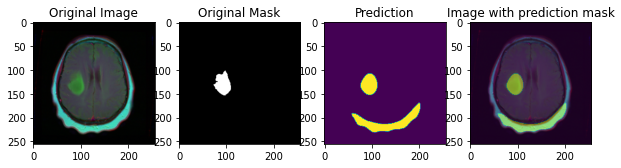

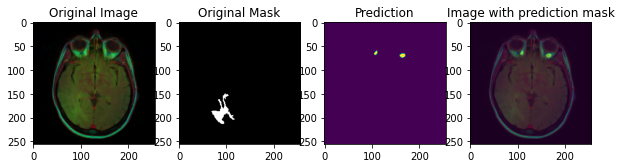

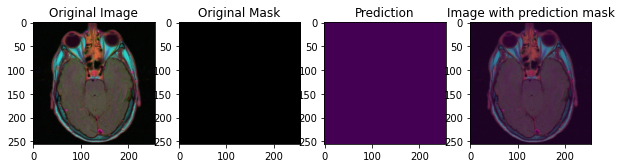

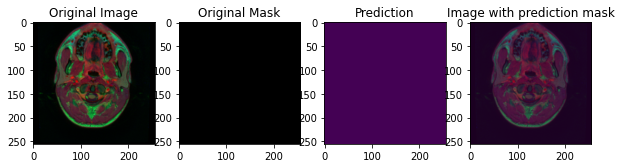

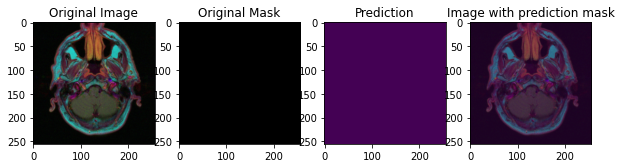

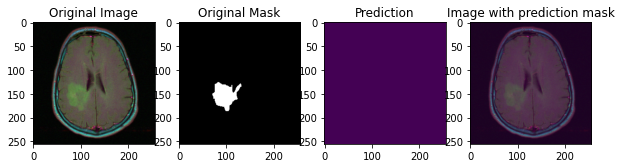

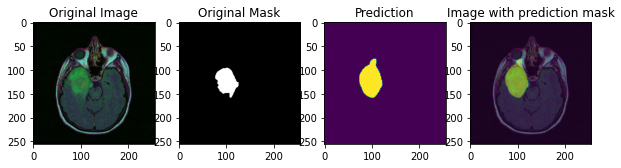

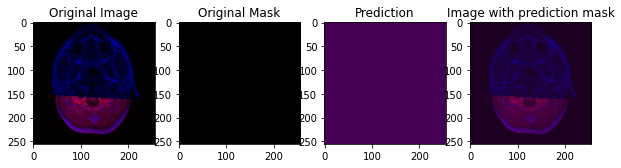

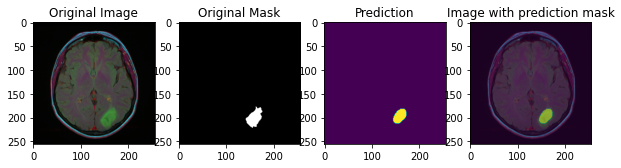

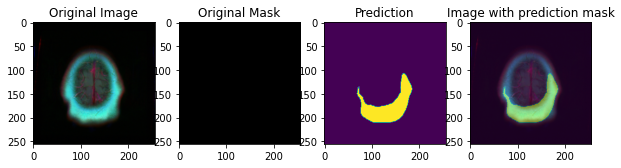

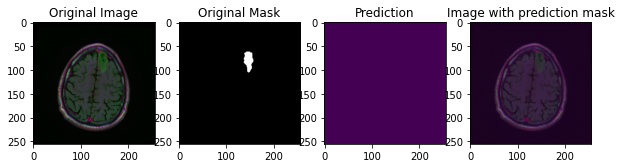

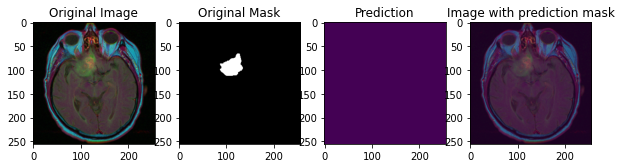

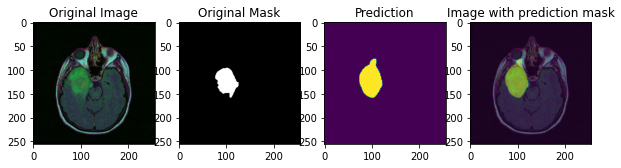

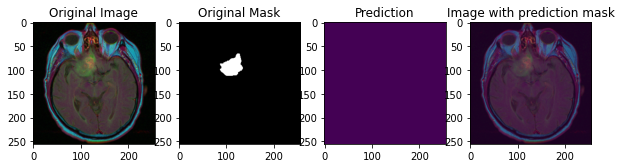

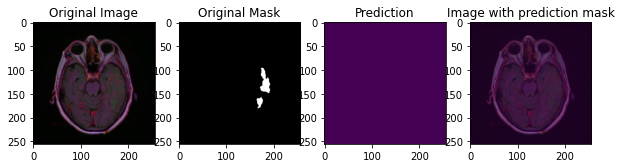

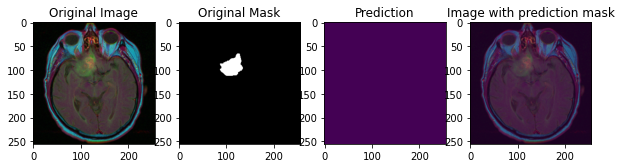

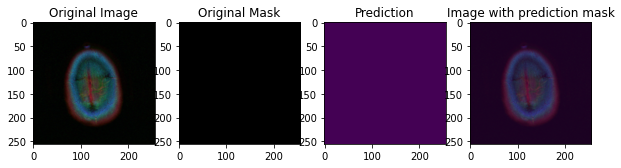

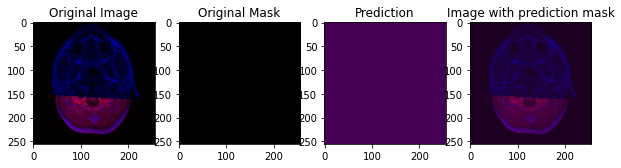

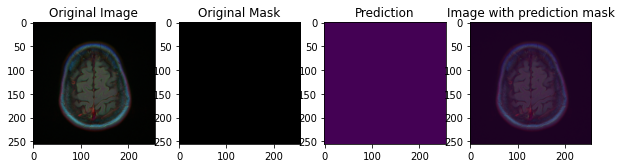

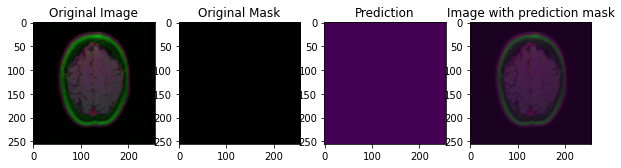

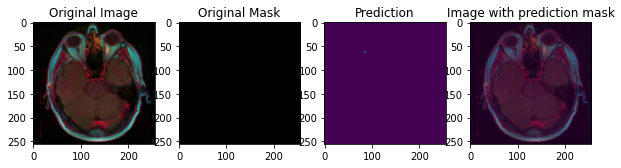

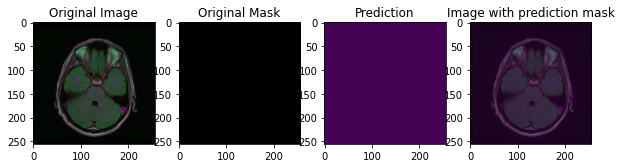

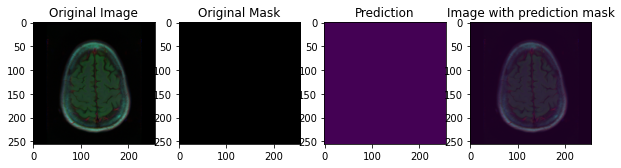

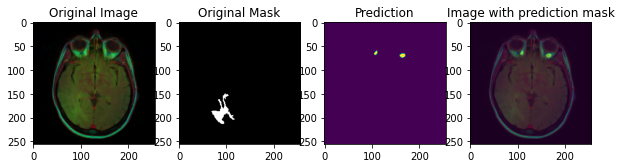

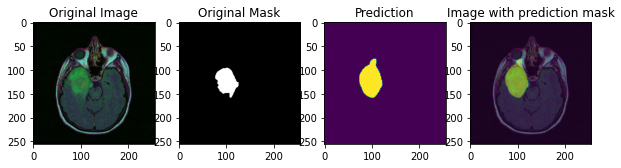

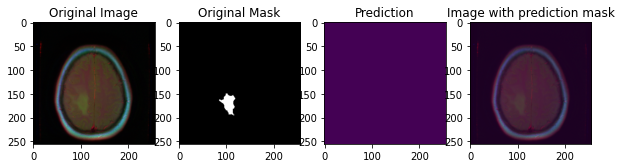

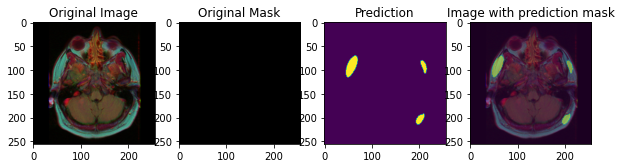

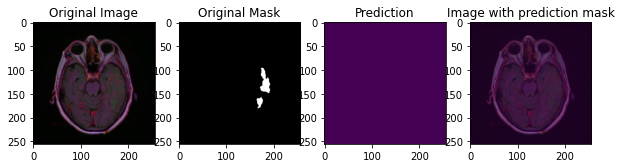

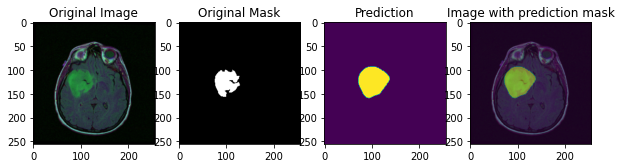

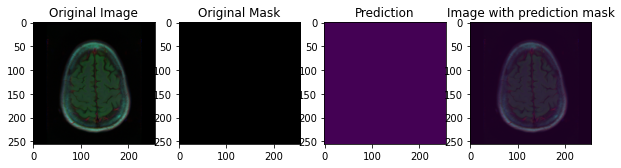

In [ ]:
import cv2
for i in range(30):
    index=np.random.randint(1,len(data_test.index))
    img = cv2.imread(data_test['images'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(cv2.imread(data_test['masks'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(img))
    plt.imshow(np.squeeze(pred)>.5,alpha=0.4)
    plt.title('Image with prediction mask')
    plt.show()